In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
import torch.nn as nn
from sklearn.preprocessing import StandardScaler

def load_file(filepath):
    dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values

def load_group(filenames, prefix=''):
    loaded = []
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    loaded = np.dstack(loaded)
    return loaded

def load_dataset_group(group, prefix=''):
    filepath = f"{prefix}{group}/Inertial Signals/"
    filenames = [
        f'total_acc_x_{group}.txt', f'total_acc_y_{group}.txt', f'total_acc_z_{group}.txt',
        f'body_acc_x_{group}.txt', f'body_acc_y_{group}.txt', f'body_acc_z_{group}.txt',
        f'body_gyro_x_{group}.txt', f'body_gyro_y_{group}.txt', f'body_gyro_z_{group}.txt'
    ]
    X = load_group(filenames, filepath)
    y = load_file(f"{prefix}{group}/y_{group}.txt")
    return X, y

def filter_static_activities(X, y):
    static_labels = [4, 5, 6]  # Sitting, Standing, Laying
    mask = np.isin(y.flatten(), static_labels)
    return X[mask], y[mask]

def relabel_classes(y):
    """ 라벨을 4,5,6 -> 0,1,2 로 변환 """
    mapping = {4: 0, 5: 1, 6: 2}
    return np.vectorize(mapping.get)(y)

def scale_data(trainX, testX):
    """ StandardScaler를 사용하여 데이터 스케일링 """
    scaler = StandardScaler()

    # (samples, timesteps, features) -> (samples * timesteps, features)
    trainX_reshaped = trainX.reshape(-1, trainX.shape[-1])
    testX_reshaped = testX.reshape(-1, testX.shape[-1])

    # StandardScaler 적용
    trainX_scaled = scaler.fit_transform(trainX_reshaped)
    testX_scaled = scaler.transform(testX_reshaped)

    # 원래 형태로 복구
    trainX_scaled = trainX_scaled.reshape(trainX.shape)
    testX_scaled = testX_scaled.reshape(testX.shape)

    return trainX_scaled, testX_scaled

def load_dataset(prefix):
    trainX, trainy = load_dataset_group('train', prefix)
    testX, testy = load_dataset_group('test', prefix)

    trainX, trainy = filter_static_activities(trainX, trainy)
    testX, testy = filter_static_activities(testX, testy)

    # 데이터 스케일링 적용
    trainX, testX = scale_data(trainX, testX)

    # 라벨을 0,1,2로 재매핑
    trainy = relabel_classes(trainy)
    testy = relabel_classes(testy)

    trainX = torch.tensor(trainX, dtype=torch.float32).permute(0, 2, 1)
    testX = torch.tensor(testX, dtype=torch.float32).permute(0, 2, 1)

    trainy = torch.tensor(trainy, dtype=torch.long).squeeze()
    testy = torch.tensor(testy, dtype=torch.long).squeeze()

    trainy_one_hot = F.one_hot(trainy, num_classes=3).float()
    testy_one_hot = F.one_hot(testy, num_classes=3).float()

    print(trainX.shape, trainy.shape, trainy_one_hot.shape, testX.shape, testy.shape, testy_one_hot.shape)
    return trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot

prefix = '/content/drive/MyDrive/Colab Notebooks/UCI-HAR/UCI-HAR/'

trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot = load_dataset(prefix)




<ipython-input-1-b34f80922149>:9: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
<ipython-input-1-b34f80922149>:9: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
<ipython-input-1-b34f80922149>:9: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
<ipython-input-1-b34f80922149>:9: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
<ipython

torch.Size([4067, 9, 128]) torch.Size([4067]) torch.Size([4067, 3]) torch.Size([1560, 9, 128]) torch.Size([1560]) torch.Size([1560, 3])


In [193]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class RevIN(nn.Module):
    def __init__(self, num_features, eps=1e-5, affine=True, subtract_last=True):
        super().__init__()
        self.num_features = num_features
        self.eps = eps
        self.affine = affine
        self.subtract_last = subtract_last
        if self.affine:
            self.affine_weight = nn.Parameter(torch.ones(1, num_features, 1))  # Change shape to (1, num_features, 1)
            self.affine_bias = nn.Parameter(torch.zeros(1, num_features, 1))  # Change shape to (1, num_features, 1)

    def forward(self, x, mode):
        if mode == 'norm':
            self._get_statistics(x)
            x = self._normalize(x)
        elif mode == 'denorm':
            x = self._denormalize(x)
        else:
            raise NotImplementedError
        return x

    def _get_statistics(self, x):
        dim = tuple(range(1, x.ndim - 1))
        if self.subtract_last:
            self.last = x[:, -1, :].unsqueeze(1)
        else:
            self.mean = x.mean(dim=dim, keepdim=True).detach()
        self.stdev = (x.var(dim=dim, keepdim=True, unbiased=False) + self.eps).sqrt().detach()

    def _normalize(self, x):
        x = (x - (self.last if self.subtract_last else self.mean)) / self.stdev
        if self.affine:
            x = x * self.affine_weight + self.affine_bias
        return x

    def _denormalize(self, x):
        if self.affine:
            x = (x - self.affine_bias) / (self.affine_weight + self.eps * self.eps)
        x = x * self.stdev + (self.last if self.subtract_last else self.mean)
        return x

def get_conv1d(in_channels, out_channels, kernel_size, stride, padding, dilation, groups, bias):
    return nn.Conv1d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride,
                     padding=padding, dilation=dilation, groups=groups, bias=bias)


def get_bn(channels):
    return nn.BatchNorm1d(channels)

def conv_bn(in_channels, out_channels, kernel_size, stride, padding, groups, dilation=1,bias=False):
    if padding is None:
        padding = kernel_size // 2
    result = nn.Sequential()
    result.add_module('conv', get_conv1d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size,
                                         stride=stride, padding=padding, dilation=dilation, groups=groups, bias=bias))
    result.add_module('bn', get_bn(out_channels))
    return result

def fuse_bn(conv, bn):

    kernel = conv.weight
    running_mean = bn.running_mean
    running_var = bn.running_var
    gamma = bn.weight
    beta = bn.bias
    eps = bn.eps
    std = (running_var + eps).sqrt()
    t = (gamma / std).reshape(-1, 1, 1)
    return kernel * t, beta - running_mean * gamma / std

class MovingAvg(nn.Module):
    def __init__(self, kernel_size, stride=1):
        super().__init__()
        self.avg = nn.AvgPool1d(kernel_size, stride, padding=0)

    def forward(self, x):
        pad = (self.avg.kernel_size - 1) // 2
        x = F.pad(x, (pad, pad), mode='replicate')
        return self.avg(x.permute(0, 2, 1)).permute(0, 2, 1)

class SeriesDecomp(nn.Module):
    def __init__(self, kernel_size):
        super().__init__()
        self.moving_avg = MovingAvg(kernel_size)

    def forward(self, x):
        trend = self.moving_avg(x)
        return x - trend, trend

class ConvFFN(nn.Module):
    def __init__(self, in_channels, out_channels, groups, dropout=0.1):
        super().__init__()
        self.ffn = nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size=1, groups=groups),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Conv1d(out_channels, in_channels, kernel_size=1, groups=groups if groups != in_channels else 1), # Changed out_channels to in_channels to ensure correct channel dimensions
            nn.Dropout(dropout)
        )

    def forward(self, x):
        return self.ffn(x)

class ReparamLargeKernelConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, small_kernel, stride=1, groups=1, small_kernel_merged=False):
        super().__init__()
        self.kernel_size = kernel_size
        self.small_kernel = small_kernel
        padding = kernel_size // 2

        if small_kernel_merged:
            self.lkb_reparam = nn.Conv1d(in_channels, out_channels, kernel_size, stride, padding, groups=groups, bias=True)
        else:
            self.lkb_origin = nn.Sequential(
                nn.Conv1d(in_channels, out_channels, kernel_size, stride, padding, groups=groups, bias=False),
                nn.BatchNorm1d(out_channels)
            )
            if small_kernel is not None:
                assert small_kernel <= kernel_size, "Small kernel must be smaller than large kernel"
                self.small_conv = nn.Sequential(
                    nn.Conv1d(in_channels, out_channels, small_kernel, stride, small_kernel // 2, groups=groups, bias=False),
                    nn.BatchNorm1d(out_channels)
                )

    def forward(self, x):
        if hasattr(self, 'lkb_reparam'):
            return self.lkb_reparam(x)
        else:
            out = self.lkb_origin(x)
            if hasattr(self, 'small_conv'):
                out += self.small_conv(x)
            return out

# Layer Norm 적용
class LayerNorm(nn.Module):
    def __init__(self, num_features, eps=1e-6):
        super().__init__()
        self.norm = nn.LayerNorm(num_features, eps=eps)

    def forward(self, x):
        return self.norm(x.transpose(-1, -2)).transpose(-1, -2)

class Flatten_Head(nn.Module):
    def __init__(self, individual, n_vars, nf, target_window, head_dropout=0.1):
        super().__init__()
        self.flatten = nn.Flatten(start_dim=-2)
        self.individual = individual

        if self.individual:
            self.linear = nn.ModuleList([nn.Linear(nf, target_window) for _ in range(n_vars)])
        else:
            self.linear = nn.Linear(nf, target_window)

        self.dropout = nn.Dropout(head_dropout)

    def forward(self, x):
        x = self.flatten(x)
        if self.individual:
            x = torch.cat([self.linear[i](x[:, i, :]) for i in range(len(self.linear))], dim=1)
        else:
            x = self.linear(x)
        return self.dropout(x)


class Stage(nn.Module):
    def __init__(self, ffn_ratio, num_blocks, large_size, small_size, dmodel, dw_model, nvars,
                 small_kernel_merged=False, drop=0.1):

        super(Stage, self).__init__()
        d_ffn = dmodel * ffn_ratio
        blks = []
        for i in range(num_blocks):
            blk = Block(dmodel=dmodel, dff=d_ffn, nvars=nvars, small_kernel_merged=small_kernel_merged, drop=drop, large_size=large_size, small_size=small_size) # Pass large_size and small_size as keyword arguments
            blks.append(blk)
        self.blocks = nn.ModuleList(blks)

    def forward(self, x):
        for blk in self.blocks:
            x = blk(x)

        return x

class ReparamLargeKernelConv(nn.Module):

    def __init__(self, in_channels, out_channels, kernel_size,
                 stride, groups,
                 small_kernel,
                 small_kernel_merged=False, nvars=7):
        super(ReparamLargeKernelConv, self).__init__()
        self.kernel_size = kernel_size
        self.small_kernel = small_kernel
        # We assume the conv does not change the feature map size, so padding = k//2. Otherwise, you may configure padding as you wish, and change the padding of small_conv accordingly.
        padding = kernel_size // 2
        if small_kernel_merged:
            self.lkb_reparam = nn.Conv1d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size,
                                         stride=stride, padding=padding, dilation=1, groups=groups, bias=True)
        else:
            self.lkb_origin = conv_bn(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size,
                                        stride=stride, padding=padding, dilation=1, groups=groups,bias=False)
            if small_kernel is not None:
                assert small_kernel <= kernel_size, 'The kernel size for re-param cannot be larger than the large kernel!'
                self.small_conv = conv_bn(in_channels=in_channels, out_channels=out_channels,
                                            kernel_size=small_kernel,
                                            stride=stride, padding=small_kernel // 2, groups=groups, dilation=1,bias=False)


    def forward(self, inputs):

        if hasattr(self, 'lkb_reparam'):
            out = self.lkb_reparam(inputs)
        else:
            out = self.lkb_origin(inputs)
            if hasattr(self, 'small_conv'):
                out += self.small_conv(inputs)
        return out


class Block(nn.Module):
    def __init__(self, dmodel, dff, nvars, large_size, small_size, small_kernel_merged=False, drop=0.1, dims=None):
        super().__init__()

        if dims is None:
            dims = [64, 128, 256]  # ✅ 기본값 추가

        kernel_size = large_size
        small_kernel = small_size

        # ✅ 수정된 부분: dims[0] 대신 dmodel 사용
        self.conv = ReparamLargeKernelConv(
            in_channels=dmodel,
            out_channels=dmodel,
            kernel_size=kernel_size,
            stride=1,
            groups=dmodel,
            small_kernel=small_kernel
        )

        self.norm = LayerNorm(dmodel)
        self.ffn = nn.Sequential(
            nn.Conv1d(dmodel, dff, kernel_size=1, groups=dmodel),
            nn.GELU(),
            nn.Dropout(drop),
            nn.Conv1d(dff, dmodel, kernel_size=1, groups=dmodel),
            nn.Dropout(drop)
        )

    def forward(self, x):
        res = x
        x = self.norm(self.conv(x))
        x = self.ffn(x)
        return res + x


class Stage(nn.Module):
    def __init__(self, ffn_ratio, num_blocks, large_size, small_size, dmodel, dw_model, nvars,
                 small_kernel_merged=False, drop=0.1, dims=None):  # ✅ dims 추가
        super(Stage, self).__init__()

        d_ffn = dmodel * ffn_ratio
        blks = []
        for i in range(num_blocks):
            blk = Block(
                dmodel=dmodel, dff=d_ffn, nvars=nvars, small_kernel_merged=small_kernel_merged,
                drop=drop, large_size=large_size, small_size=small_size, dims=dims  # ✅ dims 전달
            )
            blks.append(blk)

        self.blocks = nn.ModuleList(blks)

    def forward(self, x):

        for blk in self.blocks:
            x = blk(x)

        return x

class ModernTCN(nn.Module):
    def __init__(self, task_name, patch_size, patch_stride, stem_ratio, downsample_ratio, ffn_ratio, num_blocks,
                 large_size, small_size, dims, dw_dims, nvars, small_kernel_merged=False, backbone_dropout=0.1,
                 head_dropout=0.1, use_multi_scale=True, revin=True, affine=True, subtract_last=False,
                 freq=None, seq_len=512, c_in=7, individual=False, target_window=96, class_drop=0., class_num=3):
        super(ModernTCN, self).__init__()

        # Store the task_name
        self.patch_size = patch_size
        self.patch_stride = patch_stride
        self.task_name = task_name  # Add this line to store the task_name
        self.downsample_ratio = downsample_ratio
        self.num_stage = len(num_blocks)
        self.class_drop = class_drop
        self.class_num = class_num

        # RevIN
        self.revin = revin
        if self.revin:
            self.revin_layer = RevIN(c_in, affine=affine, subtract_last=subtract_last)

        # 🔹 stem 레이어 정의
        self.stem = nn.Sequential(
            nn.Conv1d(in_channels=nvars, out_channels=dims[0], kernel_size=patch_size, stride=patch_stride),
            nn.BatchNorm1d(dims[0])
        )

        self.downsample_layers = nn.ModuleList()
        self.downsample_layers.append(self.stem)

        if self.num_stage > 1:
            for i in range(self.num_stage - 1):
                downsample_layer = nn.Sequential(
                    nn.BatchNorm1d(dims[i]),
                    nn.Conv1d(dims[i], dims[i + 1], kernel_size=downsample_ratio, stride=downsample_ratio),
                )
                self.downsample_layers.append(downsample_layer)

        self.stages = nn.ModuleList()
        for stage_idx in range(self.num_stage):
            layer = Stage(ffn_ratio, num_blocks[stage_idx], large_size[stage_idx], small_size[stage_idx],
                          dmodel=dims[stage_idx], dw_model=dw_dims[stage_idx], nvars=nvars,
                          small_kernel_merged=small_kernel_merged, drop=backbone_dropout)
            self.stages.append(layer)

        # head 정의
        patch_num = seq_len // patch_stride
        self.n_vars = nvars
        self.individual = individual
        d_model = dims[self.num_stage-1]

        if use_multi_scale:
            self.head_nf = d_model * patch_num
            self.head = Flatten_Head(self.individual, self.n_vars, self.head_nf, target_window,
                                     head_dropout=head_dropout)
        else:
            if patch_num % pow(downsample_ratio, (self.num_stage - 1)) == 0:
                self.head_nf = d_model * patch_num // pow(downsample_ratio, (self.num_stage - 1))
            else:
                self.head_nf = d_model * (patch_num // pow(downsample_ratio, (self.num_stage - 1)) + 1)

            self.head = Flatten_Head(self.individual, self.n_vars, self.head_nf, target_window,
                                     head_dropout=head_dropout)

        if task_name == 'classification':
            self.act_class = F.gelu
            self.class_dropout = nn.Dropout(self.class_drop)
            self.head_class = nn.Linear(nvars * self.head_nf, self.class_num)

    def forward_feature(self, x, te=None):
        B, M, L = x.shape
        x = x.permute(0, 2, 1)

        for i in range(self.num_stage):
            B, C, N = x.shape

            if i == 0 and self.patch_size != self.patch_stride:
                pad_len = self.patch_size - self.patch_stride
                pad = x[:, :, -1:].repeat(1, 1, pad_len)
                x = torch.cat([x, pad], dim=-1)

            if N % self.downsample_ratio != 0:
                pad_len = self.downsample_ratio - (N % self.downsample_ratio)
                x = torch.cat([x, x[:, :, -pad_len:]], dim=-1)

            # ✅ 수정된 부분: BatchNorm1d가 아닌 Conv1d에서 in_channels를 확인
            if i > 0 and x.shape[1] != self.downsample_layers[i][1].in_channels:  # ✅ [0] -> [1]으로 변경
                x = x.permute(0, 2, 1)
                x = x.permute(0, 2, 1)

            x = self.downsample_layers[i](x)
            x = self.stages[i](x)

        return x

    def forward(self, x, te=None):
        if self.task_name == 'classification':
            x = self.forward_feature(x)
        return x

    def structural_reparam(self):
        for m in self.modules():
            if hasattr(m, 'merge_kernel'):
                m.merge_kernel()


import torch
import torch.nn as nn
from torch.nn import TransformerEncoder, TransformerEncoderLayer

class DOLGLayer(nn.Module):
    """ DOLG-style feature fusion layer """
    def __init__(self, input_dim, s3_dim, reduction_dim):
        super(DOLGLayer, self).__init__()
        self.fc_t = nn.Linear(input_dim, s3_dim, bias=True)
        self.localmodel = nn.Linear(input_dim, s3_dim, bias=True)
        self.fc = nn.Linear(s3_dim * 2, reduction_dim, bias=True)

    def forward(self, embed1, embed2):
        # Reshape embed1 before passing to localmodel
        embed1 = embed1.mean(dim=-1)  # Average along the sequence dimension


        fg = self.fc_t(embed2)  # Global feature transformation
        fg_norm = torch.norm(fg, p=2, dim=1, keepdim=True)

        fl = self.localmodel(embed1)  # Local feature transformation
        proj = torch.sum(fg * fl, dim=1, keepdim=True) / (fg_norm ** 2 + 1e-6)
        proj = proj * fg
        fo = fl - proj  # Orthogonal complement

        final_feat = torch.cat((fg, fo), dim=1)  # Concatenate features
        global_feature = self.fc(final_feat)  # Final transformation
        return global_feature

import torch
import torch.nn as nn
from torch.nn import TransformerEncoder, TransformerEncoderLayer

import torch
import torch.nn as nn
from torch.nn import TransformerEncoder, TransformerEncoderLayer

import torch
import torch.nn as nn
from torch.nn import TransformerEncoder, TransformerEncoderLayer

class Model(nn.Module):
    def __init__(self, configs):
        super(Model, self).__init__()  # ✅ 부모 클래스 초기화

        self.revin = configs.get('revin', False)

        if self.revin:
            self.revin_layer = RevIN(configs['input_dim'], affine=configs.get('affine', True), subtract_last=configs.get('subtract_last', False))

        self.tcn = ModernTCN(
            task_name='classification',
            nvars=configs['input_dim'],
            class_num=configs['output_dim'],
            patch_size=configs['kernel_size'],
            small_size=configs['small_size'],
            target_window=configs['target_window'],
            num_blocks=configs['num_blocks'],
            dims=configs['dims'],
            dw_dims=configs['dw_dims'],
            backbone_dropout=configs['dropout'],
            patch_stride=configs['patch_stride'],
            stem_ratio=configs['stem_ratio'],
            downsample_ratio=configs['downsample_ratio'],
            ffn_ratio=configs['ffn_ratio'],
            large_size=configs['large_size']
        )

        self.dolg = DOLGLayer(
            input_dim=configs['dims'][-1],  # ModernTCN의 최종 출력 차원
            s3_dim=configs['s3_dim'],
            reduction_dim=configs['output_dim']
        )


        encoder_layers = TransformerEncoderLayer(
            d_model=configs['dims'][-1],  # ModernTCN의 최종 출력 차원
            nhead=configs['num_heads'],
            dim_feedforward=configs['dim_feedforward'],
            dropout=configs['dropout'],
            batch_first=True
        )



        self.transformer_encoder = TransformerEncoder(encoder_layers, num_layers=int(configs['num_stages']))
        self.projection = nn.Linear(configs['output_dim'], configs['output_dim'])

    def forward(self, x):
        """ 🔹 모델의 순전파 (Forward) 함수 구현 """

        if self.revin:
            x = self.revin_layer(x, mode='norm')

        # 입력 데이터를 Conv1d가 처리할 수 있도록 변환
        x = x.permute(0, 2, 1)  # ✅ (batch, seq_len, channels) -> (batch, channels, seq_len)

        # TCN 통과
        x_tcn = self.tcn(x)  # ModernTCN의 출력

        # Transformer Encoder 통과
        x_transformer = self.transformer_encoder(x_tcn.permute(0, 2, 1))
        x_transformer = x_transformer.permute(0, 2, 1).mean(dim=-1)

        # DOLG 적용
        x = self.dolg(x_tcn, x_transformer)  # 차원 맞추기 필요

        # 최종 프로젝션
        x = self.projection(x)

        return x

In [194]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import f1_score
import numpy as np

class LabelSmoothingCrossEntropy(nn.Module):
    def __init__(self, smoothing=0.0):
        super(LabelSmoothingCrossEntropy, self).__init__()
        self.smoothing = smoothing

    def forward(self, input, target):
        log_prob = F.log_softmax(input, dim=-1)
        weight = input.new_ones(input.size()) * \
                 self.smoothing / (input.size(-1) - 1.)
        weight.scatter_(-1, target.unsqueeze(-1), (1. - self.smoothing))
        loss = (-weight * log_prob).sum(dim=-1).mean()
        return loss

def train_model(model, train_loader, test_loader, epochs=20, lr=0.001, device='cuda'):
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = LabelSmoothingCrossEntropy(smoothing=0.1)

    for epoch in range(epochs):
        model.train()
        total_loss = 0.0
        correct = 0
        total = 0

        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == y_batch).sum().item()
            total += y_batch.size(0)

        print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(train_loader):.4f}, Accuracy: {correct/total:.4f}")

    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == y_batch).sum().item()
            total += y_batch.size(0)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())

    f1 = f1_score(all_labels, all_preds, average='macro')
    print(f"Test Accuracy: {correct/total:.4f}, F1 Score: {f1:.4f}")
    return model

# 데이터 로드
batch_size = 32
train_dataset = TensorDataset(trainX, trainy)
test_dataset = TensorDataset(testX, testy)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 모델 초기화
configs = {
    'input_dim': 9,
    'output_dim': 3,
    'kernel_size': 11,
    'small_size': [3, 3, 3],
    'target_window': 96,
    'num_blocks': [2, 2, 2],
    'dims': [64, 128, 256],  # Ensure this is divisible by num_heads
    'dw_dims': [64, 128, 256],
    'dropout': 0.1,
    'patch_stride': 1,
    'stem_ratio': 1,
    'downsample_ratio': 2,
    'ffn_ratio': 4,
    'large_size': [11, 7, 5],
    's3_dim': 128,
    'dim_feedforward': 512,
    'num_stages': 3,
    'num_heads': 8,  # Changed from 9 to 8 (256 is divisible by 8)
    'revin': True
}

# 🔹 모델 초기화
model = Model(configs)

# 모델 훈련
trained_model = train_model(model, train_loader, test_loader, epochs=50, lr=0.001)


Epoch [1/50], Loss: 0.5932, Accuracy: 0.8753
Epoch [2/50], Loss: 0.5493, Accuracy: 0.9071
Epoch [3/50], Loss: 0.5427, Accuracy: 0.9048
Epoch [4/50], Loss: 0.5300, Accuracy: 0.9189
Epoch [5/50], Loss: 0.5214, Accuracy: 0.9257
Epoch [6/50], Loss: 0.5765, Accuracy: 0.8987
Epoch [7/50], Loss: 0.5305, Accuracy: 0.9356
Epoch [8/50], Loss: 0.5118, Accuracy: 0.9393
Epoch [9/50], Loss: 0.4978, Accuracy: 0.9562
Epoch [10/50], Loss: 0.4829, Accuracy: 0.9589
Epoch [11/50], Loss: 0.4830, Accuracy: 0.9609
Epoch [12/50], Loss: 0.4788, Accuracy: 0.9639
Epoch [13/50], Loss: 0.4668, Accuracy: 0.9678
Epoch [14/50], Loss: 0.4600, Accuracy: 0.9744
Epoch [15/50], Loss: 0.4579, Accuracy: 0.9742
Epoch [16/50], Loss: 0.4502, Accuracy: 0.9774
Epoch [17/50], Loss: 0.4449, Accuracy: 0.9803
Epoch [18/50], Loss: 0.4465, Accuracy: 0.9825
Epoch [19/50], Loss: 0.4495, Accuracy: 0.9781
Epoch [20/50], Loss: 0.4413, Accuracy: 0.9835
Epoch [21/50], Loss: 0.4542, Accuracy: 0.9796
Epoch [22/50], Loss: 0.4400, Accuracy: 0.98

Test Accuracy: 0.9750
Precision: 0.9753, Recall: 0.9741, F1 Score: 0.9745


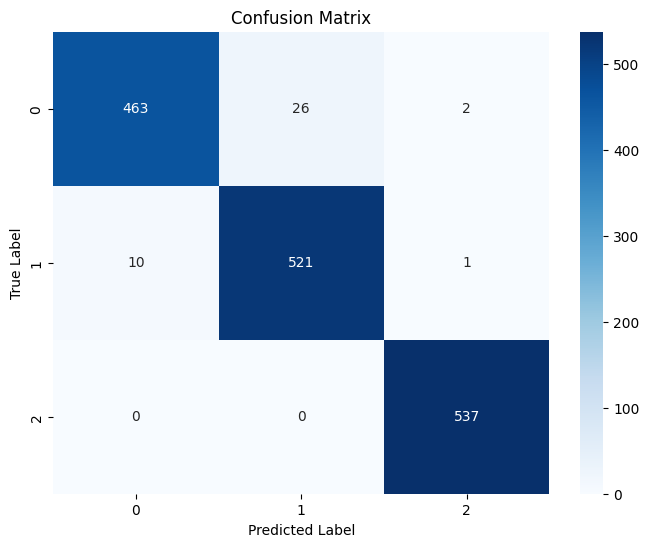

In [212]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, confusion_matrix

# 모델 장치 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

# 모델 평가 함수
def evaluate_model(model, test_loader, device):
    model.to(device)
    model.eval()

    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == y_batch).sum().item()
            total += y_batch.size(0)
            all_preds.extend(predicted.cpu().tolist())
            all_labels.extend(y_batch.cpu().tolist())

    if total == 0:
        print("테스트 데이터가 없습니다.")
        return

    # 평가 지표 계산
    accuracy = correct / total
    f1 = f1_score(all_labels, all_preds, average='macro')
    precision = precision_score(all_labels, all_preds, average='macro')
    recall = recall_score(all_labels, all_preds, average='macro')

    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")

    # Confusion Matrix 계산 및 시각화
    cm = confusion_matrix(all_labels, all_preds)
    labels = np.unique(all_labels)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

# 모델 평가 실행
evaluate_model(model, test_loader, device)



In [205]:
import torch

# 모델 저장 (가중치만 저장)
torch.save(model.state_dict(), "model_weights.pth")

# 모델 불러오기 (동일한 모델 구조를 먼저 정의해야 함)
model.load_state_dict(torch.load("model_weights.pth"))
model.eval()  # 평가 모드로 설정


<ipython-input-205-a370004e32d6>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("model_weights.pth"))


Model(
  (revin_layer): RevIN()
  (tcn): ModernTCN(
    (revin_layer): RevIN()
    (stem): Sequential(
      (0): Conv1d(9, 64, kernel_size=(11,), stride=(1,))
      (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (downsample_layers): ModuleList(
      (0): Sequential(
        (0): Conv1d(9, 64, kernel_size=(11,), stride=(1,))
        (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): Sequential(
        (0): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): Conv1d(64, 128, kernel_size=(2,), stride=(2,))
      )
      (2): Sequential(
        (0): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): Conv1d(128, 256, kernel_size=(2,), stride=(2,))
      )
    )
    (stages): ModuleList(
      (0): Stage(
        (blocks): ModuleList(
          (0-1): 2 x Block(
            (conv): ReparamLargeKernelConv(
 